### Daily Observations

- To do list

- Remove patients that are in the 0.004 of the few missing symptoms
- It would be better to look at the distribution before actually removing everything (done below) as some symptoms might be checked hourly

#### 
Please note that due to the low ammount of negative patients tested positive for Ebola,the daily observations data will be used for prognosis and not diagnosis. That is, we will try and predict the outcome for patients that contracted the Ebola Virus. This shows will be further discussed below.

We reckon the cause for the low ebola negative numbers compared to the linelist dataset is because people who are tested positive would be more likely to be sent to Guéckédou (the clinic). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pyreadstat
import datetime

In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Cedric\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

In [2]:
from proj2_HELPERS_ import *


from yellowbrick.model_selection import ValidationCurve

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [3]:
df_line = pd.read_csv('../../../../Data_project2/part_2/EGOYQN_Gueckedou_linelist_cleaned_pos_and_neg_2019_November_ANSI.csv', encoding = 'ISO-8859-1')
df_line.head()

,msfid,mcid,datmac,transit,admis,gkdid,datgck,age,sex,respref,...,pcr2ct,epistat,commun,currstat,exdat,outold,outcome,locdec,condat,source
0,G1,Absent,01/01/1900,Non,Non,Absent,01/01/1900,60.0,2,14,...,.,2,1,1,2/22/2014,3,2,GUECKEDOU,02/02/2014,.
1,G10,Absent,01/01/1900,Non,Non,Absent,01/01/1900,35.0,2,14,...,.,1,0,1,3/17/2014,1,2,Hosto GKD,2/25/2014,.
2,G100,Absent,01/01/1900,Non,Oui,GKD25,04/11/2014,40.0,1,14,...,.,1,0,2,4/20/2014,8,1,na,01/01/1900,.
3,G1000,MC260,9/17/2014,Non,Oui,GKD775,01/01/1900,40.0,1,25,...,.,1,0,1,9/19/2014,3,2,Non rempli,01/01/1900,.
4,G1001,Absent,9/17/2014,Non,Oui,GKD776,9/19/2014,8.0,2,25,...,.,1,0,1,9/21/2014,3,2,Non rempli,01/01/1900,.


In [4]:
df_clinical = pd.read_csv('../../../../Data_project2/part_2/EGOYQN_Gueckedou_clinFU_cleaned_pos_and_neg_2019_November.csv', encoding = 'ISO-8859-1')
df_clinical.head()

C:\Users\Cedric\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,mningit,encphal,erysip,cardio,fessier,epilep,mendis,otherco,notesread,dup
0,G100,4/14/2014,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
1,G100,4/14/2014,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
2,G100,4/16/2014,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
3,G100,4/15/2014,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0
4,G100,4/15/2014,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,.,.,.,.,.,.,.,.,0


#### Ebola tested patients in Linelist

Apply dictionary to ebola data
where 1 is positive, 0 is negative and -1 unknown
2 is probable and we decided to put it in the positive category, 3 and 9 are unknwon 

In [5]:
df_line['epistat'].value_counts(dropna=False)

1    1372
0     978
2     135
3      13
9       2
Name: epistat, dtype: int64

In [6]:
dict_ebola_answer = {0:0, 1:1, 2:1, 3:-1, 9:-1, '.':-1}
df_line['epistat'] = df_line['epistat'].apply(lambda x : dict_ebola_answer[x])


In [7]:
df_line['epistat'].value_counts()

 1    1507
 0     978
-1      15
Name: epistat, dtype: int64

To the Clinical data we add the "epistat" (positive/negative to Ebola) feature from the linelist datafile, the "datsym" representing the estimated start of symptoms and the "outcome" (Death/survival), the outcome, the age and the sex of the patients

We create a new feature name "dt" which takes the difference of time between the appearance of the first symptoms and the admittance to the clinic. 

In [8]:
# Joining the data_sets 
df_clinical= df_clinical.join(df_line.set_index('msfid')[['datsym', 'epistat', 'outcome', 'age', 'sex']], on='msfid')


df_clinical.datclin = pd.to_datetime(df_clinical.datclin)
df_clinical.datsym = pd.to_datetime(df_clinical.datsym)

# Create feature with difference in dates between start of symptoms and start at the clinic
df_clinical['dt'] = (df_clinical.datclin - df_clinical.datsym).dt.days

In [9]:
df_clinical

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,mendis,otherco,notesread,dup,datsym,epistat,outcome,age,sex,dt
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,5.0
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,5.0
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,7.0
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,6.0
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,.,.,0,2014-04-09,1.0,1,40.0,1.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13761,G1841,2014-11-20,9,G1841_20nov2014_9,0,0,0,0,8,8,...,8,.,Yes,0,2014-11-05,1.0,1,40.0,1.0,15.0
13762,G1841,2014-11-20,16,G1841_20nov2014_16,0,0,0,0,8,8,...,8,.,Yes,0,2014-11-05,1.0,1,40.0,1.0,15.0
13763,G1841,2014-11-21,9,G1841_21nov2014_9,0,0,0,0,8,8,...,8,.,Yes,0,2014-11-05,1.0,1,40.0,1.0,16.0
13764,G1934,2014-11-16,9,G1934_16nov2014_9,1,1,1,1,1,0,...,8,NaN,Yes,0,2014-11-12,1.0,1,40.0,1.0,4.0


In [10]:
df_clinical['dt'].value_counts()

 7.0        1154
 5.0        1106
 6.0        1100
 8.0        1094
 4.0         957
            ... 
-41775.0       1
-41735.0       1
-41727.0       1
-41726.0       1
-41805.0       1
Name: dt, Length: 105, dtype: int64

In [11]:
# Let's have a look at people whose symptoms appears before their admittance
df_clinical[df_clinical['dt'] < 0]['dt'].value_counts()

-1.0        7
-3.0        4
-41895.0    3
-4.0        3
-41882.0    3
-41864.0    3
-2.0        2
-41881.0    2
-41865.0    2
-41896.0    2
-41870.0    2
-6.0        2
-41880.0    2
-5.0        2
-41775.0    1
-41956.0    1
-41735.0    1
-41939.0    1
-41805.0    1
-41897.0    1
-41893.0    1
-41726.0    1
-41925.0    1
-41883.0    1
-41869.0    1
-41862.0    1
-41871.0    1
-41727.0    1
-41868.0    1
Name: dt, dtype: int64

In [12]:
# We remove obersvation with absurd values, here set at a difference of over 40 thousand days
# removed 34 observations
df_clinical = df_clinical[df_clinical['dt'] > -40000]

In [13]:
df_clinical['msfid'].nunique()

769

#### Before separating the dataframe by day and concatenating it, we'll proceed in doing some data visualization on the features


#### Ebola

In [14]:
# Ebola positive samples
df_clinical[df_clinical['epistat'] == 1].count()

msfid      13423
datclin    13423
timclin    13423
unid       13423
ceph       13423
           ...  
epistat    13423
outcome    13423
age        13423
sex        13423
dt         13423
Length: 119, dtype: int64

In [15]:
# Ebola negative samples
df_clinical[df_clinical['epistat'] == 0].count()

msfid      132
datclin    132
timclin    132
unid       132
ceph       132
          ... 
epistat    132
outcome    132
age        132
sex        132
dt         132
Length: 119, dtype: int64

In [16]:
# We only have 12 unique patients in Clinical that at some point compared to 769 patients
df_clinical[df_clinical['epistat'] == 0].nunique()

msfid       12
datclin     35
timclin     18
unid       130
ceph         2
          ... 
epistat      1
outcome      2
age         12
sex          3
dt          17
Length: 119, dtype: int64

We will therefore only look at prognosis and not diagnosis, let us drop the patients that are ebola negative

In [17]:
df_clinical = df_clinical[df_clinical['epistat'] != 0]

In [18]:
# Sanity check
df_clinical['epistat'].value_counts(dropna = False)

1.0    13423
Name: epistat, dtype: int64

### Age

Replace the few unknown edges with the median of the known ones

In [19]:
(df_clinical['age']== 999).sum()


138

In [20]:
df_clinical['age'].replace(999, np.nan, inplace = True)

In [21]:
# Remplace the nan values by the median age
df_clinical['age'].fillna(df_line['age'].median(),inplace = True)

### Sex

In [22]:
df_sex = df_clinical['sex']

dict_sex = {1: 1 ,2:0, 9: -1}
df_sex = df_sex.apply(lambda x : dict_sex[x])



### Fever temperature

In [23]:
sum(df_clinical['fevtemp'].isna())

0

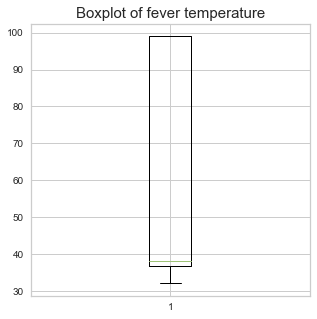

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of fever temperature",size=15)
plt.boxplot(df_clinical['fevtemp'])
plt.show()

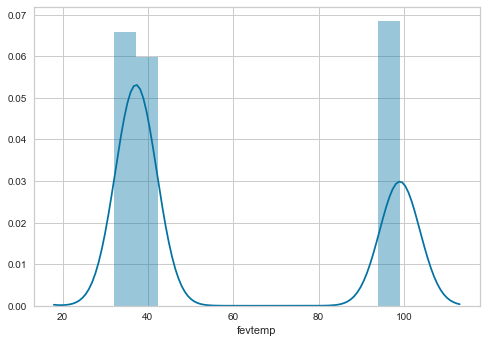

In [25]:
sns.distplot(df_clinical["fevtemp"])
plt.show()

We see a peak at 99, these will be missing values.
We thought they might be given in fareinheit but the value counts tells us different (since only 99's and no "ditribution") If we had a distribtion around 99 we could expect different units

In [26]:
df_clinical["fevtemp"].value_counts()

99.0    4737
37.0     425
36.7     412
36.6     390
36.4     350
        ... 
32.1       1
33.1       1
33.7       1
32.7       1
32.9       1
Name: fevtemp, Length: 90, dtype: int64

## Distribution of time spent at the clinic

We are interested into looking at the possible evolution of the patients at the clinic for a few days in a row to see how the symptoms and other features will influence the outcome. Knowing the likely causes and symptoms that make you more prone to decease would increase the chance of making good decisions for the nurses and doctors

In [27]:
# First day of patient at the clinic
df_min = pd.DataFrame(df_clinical.groupby(by = 'msfid').datclin.min()).reset_index().rename(columns={'datclin':'first_date'})

df_min

,msfid,first_date
0,G100,2014-04-11
1,G1000,2014-09-17
2,G1001,2014-09-17
3,G1002,2014-09-17
4,G1004,2014-09-18
...,...,...
752,G993,2014-09-16
753,G994,2014-09-18
754,G996,2014-09-19
755,G998,2014-09-17


In [28]:
# Merge with original data frame
df_mer_date = df_clinical.merge(df_min, on = 'msfid', how = 'left')


In [29]:
# Time stayed at the clinic. We look at unique dates since the observations are daily
df_stay = pd.DataFrame(df_clinical.groupby(by = 'msfid').datclin.nunique()).reset_index().rename(columns={'datclin':'Time_stayed'})

df_stay

,msfid,Time_stayed
0,G100,10
1,G1000,2
2,G1001,3
3,G1002,18
4,G1004,3
...,...,...
752,G993,11
753,G994,7
754,G996,3
755,G998,9


Text(0.5, 0, 'Number of days')

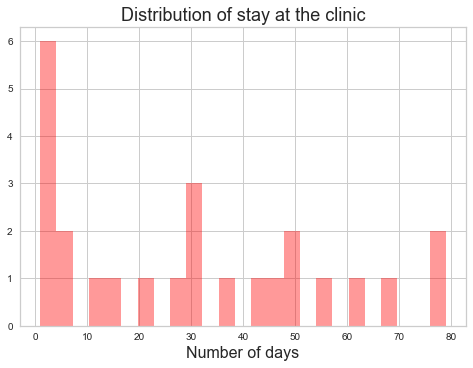

In [30]:

#df_stay['Time_stayed'].value_counts().hist(bins = 25)

sns.distplot(df_stay['Time_stayed'].value_counts(), kde=False, color='red', bins=25)
plt.title('Distribution of stay at the clinic', fontsize=18)
plt.xlabel('Number of days', fontsize=16)


In [31]:
df_stay['Time_stayed'].value_counts().sort_values(ascending = False)

3     79
5     79
2     68
4     63
7     56
8     49
9     49
6     45
10    42
11    37
12    30
13    30
15    30
1     29
14    20
17    15
16    12
19     6
18     5
21     4
20     3
24     2
22     2
23     1
25     1
Name: Time_stayed, dtype: int64

## *The results above, allow us to decide we'll take patients that have stayed at least 5 days, this will enable us to keep as much continious data as possible in this dataset* 
We decided to keep 5 instead of 3, this would indeed yield to less patients, but we would get a better reprsentation of delevopments (of symptoms) over time

In [32]:
# How many patients stayed 5 or more days
tot_patients = (df_stay['Time_stayed']> 4).sum()
(df_stay['Time_stayed']> 4).sum()

518

In [33]:
df_stay['Time_stayed'].value_counts().sum()

757

We keep 518 patients out of 757 !

In [34]:
# We keep the frames of people staying 5 days or more
df_selected = df_stay[(df_stay['Time_stayed']> 4)] 
df_selected

,msfid,Time_stayed
0,G100,10
3,G1002,18
5,G1005,7
6,G1006,9
7,G1007,8
...,...,...
750,G991,9
751,G992,5
752,G993,11
753,G994,7


In [35]:
df_selected_ml = df_mer_date.merge(df_selected, on = 'msfid', how = 'inner')
df_selected_ml

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
2,G100,2014-04-16,9,G100_16apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,7.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12048,G2493,2015-01-14,17,G2493_14jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12049,G2493,2015-01-15,6,G2493_15jan2015_6,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,14.0,2015-01-10,9
12050,G2493,2015-01-13,9,G2493_13jan2015_9,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9
12051,G2493,2015-01-13,17,G2493_13jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9


Now that we have the dataframe of the patients who stay for more than 5 days, we should take the five first days for the patients. In order to make a "symmetric" dataframe. Otherwise when contcatenating on the days spent at the clinic, those who stayed more than five would have more columns but not the ones that stayed exactly five days.

Taking the first five days for a patient that stayed longer might/will cause some bias in the model as that patient may feel better the first five days and then have their health state diminish (possibly explained the extended time at the clinic)

In [36]:

# strictly inferior to 5 because we start at 0 :) 
df_5_days = df_selected_ml[df_selected_ml['datclin']- df_selected_ml['first_date'] < '5 days']

df_5_days

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
5,G100,2014-04-15,9,G100_15apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,G2493,2015-01-14,6,G2493_14jan2015_6,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12048,G2493,2015-01-14,17,G2493_14jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12050,G2493,2015-01-13,9,G2493_13jan2015_9,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9
12051,G2493,2015-01-13,17,G2493_13jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9


### Daily observations fusion 

In order to get the most possible information out of the data set, we will fuse the days with one another. We make the following assumptions:
- If the patient has a symptom at some hour of the day, the patient will be positive for that symptom during the whole day
- For the temperature we take the mean within the day

It is possible the doctors make specific tests at specific hours and being negative at one hour in all symptoms but not the following would yield into removing that observation, but this may just be because of specific tests at sepcific times.



# Fuse the observations that were taken on the same day

In [37]:
list_of_symptoms=[]
for i, name in enumerate(df_5_days.columns):
    if all(str(x) in ['0', '1', '2', '3', '8', '9', "."] for x in list(df_5_days[name].value_counts().index)):
        if name != 'outcome':  # We don't take the 'outcome' because this will be our target labels so they will be added to the final dataframe later
            list_of_symptoms.append(name)

list_of_constants = []
for i, name in enumerate(df_5_days.columns):
    grouped = df_5_days.groupby(by= ['msfid', 'datclin']).nunique()
    if name not in ['msfid', 'datclin', 'outcome']: # outcome is for later
        if grouped[name].sum() == len(grouped[name]): # if the sum on the column = its lenght => it had only 1's => only 1 unique element per day
            list_of_constants.append(name)

In [38]:
print(list_of_symptoms)
print(list_of_constants)

['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc', 'convc', 'swallow', 'hiccups', 'anorc', 'nausc', 'vomit', 'abdopain', 'abdosens', 'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'resp', 'chestpain', 'vertpain', 'lombar', 'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc', 'occulair', 'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj', 'epista', 'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl', 'injbl', 'petc', 'parat', 'coartt', 'artest', 'ppnt', 'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt', 'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz', 'cta', 'metro', 'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro', 'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso', 'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc', 'perfal', 'malari', 'hivpos', 'mningit', 'encphal', 'erysip', 'cardio', 'fessier', 'epilep', 'mendis', 'dup']
['datsym', 'epistat', 'age', 'sex', 'dt', 'first_date', 'Ti

In [39]:
# Sanity check : we don't want an overlap of the lists
print(set(list_of_symptoms) & set(list_of_constants))

set()


In [40]:
def merger_for_const(df, list_of_constants): # fuse entries accross the day for when they are the same
    df_cut = df[['msfid', 'datclin'] + list_of_constants].copy() 
    df_fusion = df_cut.groupby(by= ['msfid', 'datclin']).head(1) # just assign the first entry of the day
    return df_fusion.set_index(['msfid', 'datclin']) # Need to specify index (.head() does not automaticlly keed the same group structure as the other methods of the class)

In [41]:
# Make a small dictionnary to reformat the symptoms 
dict_read_symptoms = {
    0  : 1,
    1  : 100,
    '0': 1,
    '1': 100,
    '9': 0,
    9  : 0,
    8  : 0,
    '8': 0,
    '.': 0
}

In [42]:
def merger_for_symptoms(df, list_of_symptoms, dict_read_symptoms): # Since you can either manifest the symptom or not, just make the sum accross the entries of the day
    # Note that this method assumes that if a symptom is present at some point of the day, the patient still has it at the end of that day
    df_cut = df[['msfid', 'datclin'] + list_of_symptoms].copy()
    df_cut[list_of_symptoms] = df_cut[list_of_symptoms].applymap(lambda x: dict_read_symptoms[x]) # use the dict. to reformat
    df_fusion = df_cut.groupby(by= ['msfid', 'datclin']).sum()
    df_fusion[df_fusion[list_of_symptoms] == 0] = np.nan # in this context, we want that 1 + 1 = 1 
    df_fusion[df_fusion[list_of_symptoms] < 99] = 0 # in this context, we want that 1 + 1 = 1 
    df_fusion[df_fusion[list_of_symptoms] > 99] = 1 # in this context, we want that 1 + 1 = 1 
    return df_fusion

In [43]:
rest = list(set(df_5_days.columns) - set(list_of_constants) - set(list_of_symptoms))
print(rest)

['othrsym', 'otherco', 'fevtemp', 'timclin', 'msfid', 'rrate', 'deshcat', 'othrtx', 'outcome', 'othrhe', 'notesread', 'conscc', 'pouls', 'bp', 'datclin', 'unid']


### Functions to treat all those odd columns
(except of course 'msfid', 'datclin','timclin'and also 'outcome')

where:
- msfid: id of the patient
- datclin: Date of observation
- timclin: Time of observation
- outcome: Survival/Death 

In [44]:
# 'otherco'
df_5_days['otherco'].value_counts()

.         4211
ABSENT     910
na         220
NR           4
absent       2
Name: otherco, dtype: int64

Missing too many, drop the column.

In [45]:
# 'notesread'
df_5_days['notesread'].value_counts()

Yes    4059
.      1461
No      429
Name: notesread, dtype: int64

Just says wether the notes were readable or not; not relevant here : will not be kept

In [46]:
# Other treatment
df_5_days['othrtx'].value_counts()

.               3338
ABSENT          1038
na               256
FAVIPIRAVIR      212
ONDANSETRON       89
                ... 
FAVPIRAVIR         1
LOPERAMIDE         1
ONDASETRON         1
TETRACICLYNE       1
ATROPINE           1
Name: othrtx, Length: 90, dtype: int64

Will not be kept

#### Pouls

In [47]:
df_5_days['pouls'] = df_5_days['pouls'].astype('int')

C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
# Total number of unique patients
tot_patients


518

In [49]:
df_5_days['pouls'] == 999

0        True
1        True
3        True
4        True
5        True
         ... 
12047    True
12048    True
12050    True
12051    True
12052    True
Name: pouls, Length: 5949, dtype: bool

In [50]:
# Missing value in pouls
missing_pouls = df_5_days[df_5_days['pouls'] == 999]['msfid'].count()
missing_pouls

5686

In [51]:
# Total number of observations
total_obvs = df_5_days['msfid'].count()
total_obvs

5949

In [52]:
ratio_pouls = missing_pouls / total_obvs
ratio_pouls

0.9557908892250798

We have a lot of missing values of the heartbeat, it's not taken at each observations. Let see if we have at least one heartbeat for each patient.

In [53]:
df_5_days[df_5_days['pouls'] != 999].groupby('msfid').pouls.count()

msfid
G1005          1
G1006          1
G1008          1
G1009          1
G1010          1
G1046          1
G1050          1
G1052          2
G1054          2
G1075          1
G1080          1
G1095          1
G1119          1
G1589         14
G1644          1
G1769          1
G1830          1
G2420          1
G571          12
G578 (Bis)     2
G582          14
G590          15
G592          19
G594          15
G595          18
G597          16
G598           7
G599           7
G600           9
G601          10
G602           7
G606           7
G607           6
G609           7
G610           3
G611           3
G613           3
G616           1
G617           4
G618           3
G621           3
G626           1
G627           1
G629           1
G634           4
G636           3
G638           3
G639           2
G640           3
G646           5
G654           1
G658           1
G659           1
G661           2
G663           3
G670           1
G671           1
G674           2
G697    

In [54]:
# Unique patients who've had their pouls measured
pouls_pat = len(df_5_days[df_5_days['pouls'] != 999].groupby('msfid').pouls.count())
pouls_pat

60

In [55]:
# Number of observations (per day) were pulse 
pouls_obs = sum(df_5_days[df_5_days['pouls'] != 999.0].groupby('msfid').pouls.count()) 

In [56]:
pouls_pat/tot_patients

0.11583011583011583

In [57]:
pouls_obs /total_obvs

0.04420911077492015

##### We only have the heartbeat for 60 unique patients, that is 11% of the cohort and only for 4.4% of the observations. 

Not enough... we drop

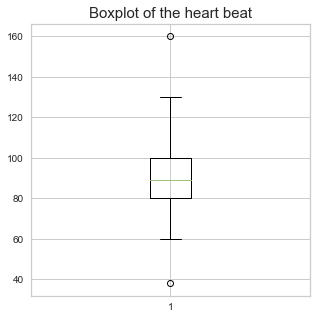

In [58]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of the heart beat",size=15)
plt.boxplot(df_5_days.loc[df_5_days['pouls'] != 999.0,'pouls'])
plt.show()

#### Blood pressure

In [59]:
df_5_days['bp'].value_counts(dropna = False)

999    3010
999    2319
100     131
80      107
90       99
110      63
70       38
90       38
120      34
100      20
80       13
70       12
120      10
60        9
60        5
10        5
130       4
110       4
11        3
7         3
160       2
150       2
50        2
12        2
75        1
114       1
111       1
74        1
78        1
104       1
180       1
15        1
99        1
125       1
8         1
10        1
130       1
40        1
Name: bp, dtype: int64

In [60]:
df_5_days['bp'].fillna(999.0, inplace = True)
df_5_days['bp'].replace('.',999, inplace = True)
# We note some values are in strings, let's make them int since we have no floats
df_5_days['bp'] = df_5_days['bp'].astype('int')

C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Cedric\Anaconda3\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [61]:
df_5_days[df_5_days['bp'] != 999.0].groupby('msfid').bp.count()

msfid
G1005    2
G1006    3
G1007    1
G1008    2
G1009    1
        ..
G989     1
G991     3
G992     3
G993     4
G994     5
Name: bp, Length: 209, dtype: int64

In [62]:
# NUmber of observations
bp_obs = sum(df_5_days[df_5_days['bp'] != 999.0].groupby('msfid').bp.count())
bp_obs

620

In [63]:
# Number of patients who got their blood pressure measured at least once
bp_pat = len(df_5_days[df_5_days['bp'] != 999.0].groupby('msfid').bp.count())
bp_pat

209

In [64]:
bp_pat/tot_patients

0.4034749034749035

In [65]:
bp_obs/total_obvs

0.10421919650361405

We have the bloodpressure for 209 patients, that is 40% of the cohort and 10 % of the observations. 

In [66]:
f = {'bp': ['count','mean', 'median', 'std', 'skew', pd.DataFrame.kurt, lambda x : x.quantile(0.25), lambda x : x.quantile(0.75)]}
df_5_days.loc[:,['msfid','bp']].groupby('msfid').agg(f).fillna(0).rename(columns={"<lambda_0>": "first quartile", "<lambda_1>": "third quartile "})

bp                                                                    \
      count        mean median         std      skew      kurt first quartile   
msfid                                                                           
G100     15  999.000000  999.0    0.000000  0.000000  0.000000         999.00   
G1002    12  999.000000  999.0    0.000000  0.000000  0.000000         999.00   
G1005     6  697.666667  999.0  466.834303 -0.968446 -1.873796         324.75   
G1006     8  661.875000  999.0  465.368805 -0.645579 -2.233894         112.50   
G1007     9  889.111111  999.0  329.666667 -3.000000  9.000000         999.00   
...     ...         ...    ...         ...       ...       ...            ...   
G991      6  552.833333  559.5  488.805653 -0.000912 -3.330768         105.00   
G992      6  553.500000  556.5  488.042109 -0.000359 -3.332308         111.00   
G993      9  592.777778  999.0  481.733271 -0.271249 -2.570875          90.00   
G994     10  545.500000  559.5  478.202944 -0.002545 -2.566421          92.50   
G998      9  999.000000  999.0    0.000000  0.000000  0.000000         999.00   

                       
      third quartile   
msfid                  
G100            999.0  
G1002           999.0  
G1005           999.0  
G1006           999.0  
G1007           999.0  
...               ...  
G991            999.0  
G992            999.0  
G993            999.0  
G994            999.0  
G998            999.0  

[518 rows x 8 columns]

We will this drop this feature as well. 

#### Respiration Rate

In [67]:
df_5_days['rrate'].value_counts(dropna = False)


999    3238
999    2435
24       32
20       31
28       28
22       27
26       26
32       25
40       17
30       14
23       10
19        9
36        9
27        8
25        7
18        4
48        4
42        3
44        3
21        2
45        2
39        2
56        2
43        1
92        1
98        1
52        1
38        1
70        1
33        1
46        1
37        1
54        1
80        1
Name: rrate, dtype: int64

In [68]:
df_5_days['rrate'].fillna(999.0, inplace = True)
df_5_days['rrate'].replace('.',999, inplace = True)
# We note some values are in strings, let's make them int since we have no floats
df_5_days['rrate'] = df_5_days['rrate'].astype('int')


C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [69]:
df_5_days[df_5_days['rrate'] != 999.0].groupby('msfid').rrate.count()

msfid
G1005          1
G1006          1
G1009          1
G1010          1
G1046          2
G1050          1
G1051          1
G1052          2
G1054          2
G1075          1
G1080          1
G1095          1
G1801          1
G1847          1
G2078          1
G571          28
G578 (Bis)     2
G582          14
G590          15
G592          22
G594          22
G595          17
G597          14
G598           7
G599           8
G600           7
G601          10
G602           7
G606           7
G607           6
G609           6
G610           3
G611           2
G613           2
G614 (bis)     3
G616           3
G617           3
G618           2
G621           3
G626           1
G627           1
G629           1
G634           4
G636           2
G638           3
G639           5
G640           3
G645           3
G646           5
G647           3
G654           1
G658           1
G659           1
G661           2
G663           4
G670           2
G671           1
G674           1
G711    

In [70]:
# Number of observations for respiration rate
rrate_obs = sum(df_5_days[df_5_days['rrate'] != 999.0].groupby('msfid').rrate.count())

In [71]:
rrate_obs/total_obvs

0.04639435199193142

In [72]:
patients_rrate = len(df_5_days[df_5_days['rrate'] != 999.0].groupby('msfid').rrate.count())
print(patients_rrate)
ratio_rrate = patients_rrate / tot_patients
ratio_rrate

59


0.1138996138996139

We have the respiration rate for 59 patients, that is 11% of the cohort and 4.6% of the observations. 

#### Other categorical symptoms

In [73]:
df_5_days['deshcat'].value_counts()

Non rempli                                4542
Pas applicable (non inclus dans fiche)    1394
B: irritable and restless, sunke             6
C: floppy baby/lethargic or unco             4
A: alert, eyes normal, not thirs             3
Name: deshcat, dtype: int64

In [74]:
dict_deshcat = {'Non rempli' : 'Unknown', 'Pas applicable (non inclus dans fiche)' : 'Unknown', \
               'A: alert, eyes normal, not thirs' : 'Alert', 'B: irritable and restless, sunke' : 'Irritable', \
               'C: floppy baby/lethargic or unco' : 'Lethargic', '.' : 'Unknown'}

df_5_days['deshcat'] = df_5_days['deshcat'].apply(lambda x: dict_deshcat[x])

C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [75]:
# deshcat () different than unknown

df_5_days.loc[df_5_days['deshcat'] != 'Unknown'].groupby('msfid').deshcat.count()

msfid
G1570    1
G1624    1
G1804    3
G1903    1
G1934    2
G2078    1
G2102    1
G645     1
G647     1
G788     1
Name: deshcat, dtype: int64

Too few values, we'll drop this feature.

### Consciousness feature 'conscc'

The Glasgow Coma Scale (GCS) is used to objectively describe the extent of impaired **consciousness** in all types of acute medical and trauma patients. The scale assesses patients according to three aspects of responsiveness: eye-opening, motor, and verbal responses. Reporting each of these separately provides a clear, communicable picture of a patient’s state.
More in https://www.ncbi.nlm.nih.gov/books/NBK513298/#:~:text=%5B1%5D%20The%20Glasgow%20Coma%20Scale,%2C%20motor%2C%20and%20verbal%20responses.

In [76]:
df_5_days['conscc'].value_counts()

Non rempli                         4011
Pas applicable (non inclus dans    1640
Alert GCS=13,14,15                  231
Voice GCS=9,10,11,12                 36
Pain GCS=4,5,6,7,8                   16
Unresponsive GCS=1,2,3               15
Name: conscc, dtype: int64

In [77]:
dict_conscc = {'Non rempli' : 'Unknown', 'Pas applicable (non inclus dans' : 'Unknown', \
               'Alert GCS=13,14,15' : 'Alert: GCS in [13,15]', 'Unresponsive GCS=1,2,3' : 'Unresponsive: GCS in [1,3]', \
               'Pain GCS=4,5,6,7,8' : 'Pain GCS in [4,8]', 'Voice GCS=9,10,11,12' : 'Voice: GCS in [9,12]', \
               '.' : 'Unknown'}

df_5_days['conscc'] = df_5_days['conscc'].apply(lambda x: dict_conscc[x])

C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
df_cons = df_5_days.loc[(df_5_days['conscc'] != 'Unknown'),['conscc','msfid']].groupby(by = 'msfid').count()

In [79]:
df_cons

,conscc
msfid,
G1002,2
G1008,1
G1009,2
G1010,2
G1021,2
...,...
G987,3
G989,1
G991,1


In [80]:
# we have 162 patients with this feature not unknown
(df_cons != 0).sum()

conscc    162
dtype: int64

In [81]:
df_5_days['unid'].value_counts()

G1579_29oct2014_9    3
G1579_31oct2014_9    3
G296_30may2014_10    3
G788_03sep2014_9     2
G1934_16nov2014_9    2
                    ..
G338_09jun2014_6     1
G1943_16nov2014_9    1
G2401_20dec2014_9    1
G442_26jun2014_99    1
G905_08sep2014_9     1
Name: unid, Length: 5885, dtype: int64

In [82]:
df_5_days

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
0,G100,2014-04-14,16,G100_14apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
1,G100,2014-04-14,12,G100_14apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,5.0,2014-04-11,10
3,G100,2014-04-15,12,G100_15apr2014_12,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
4,G100,2014-04-15,16,G100_15apr2014_16,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
5,G100,2014-04-15,9,G100_15apr2014_9,0,0,0,0,.,0,...,.,0,2014-04-09,1.0,1,40.0,1.0,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,G2493,2015-01-14,6,G2493_14jan2015_6,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12048,G2493,2015-01-14,17,G2493_14jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,13.0,2015-01-10,9
12050,G2493,2015-01-13,9,G2493_13jan2015_9,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9
12051,G2493,2015-01-13,17,G2493_13jan2015_17,0,0,0,0,0,0,...,Yes,0,2015-01-01,1.0,1,20.0,1.0,12.0,2015-01-10,9


In [83]:
def merger_for_weird(df, name_of_column): # just take the first non-null entry of the day (and hope it's the only one)
    df_cut = df[['msfid', 'datclin', name_of_column]].copy()
    df_cut[df_cut[name_of_column] == '.'] = np.nan
    df_cut[df_cut[name_of_column] == 'na'] = np.nan
    df_cut[df_cut[name_of_column] == 'ABSENT'] = np.nan
    df_cut[df_cut[name_of_column] == 'Non rempli'] = np.nan
    df_cut[df_cut[name_of_column] == 'Unknown'] = np.nan
    df_cut[df_cut[name_of_column] == 'Pas applicable (non inclus dans'] = np.nan
    df_fusion = df_cut.groupby(by=['msfid', 'datclin']).nth(0, dropna='any') # take the first (array start at 0) non-null element of the group
    return df_fusion

In [84]:
def merger_for_means(df, name_of_column): # will take the mean of entries accros the day
    df_cut = df[['msfid', 'datclin', name_of_column]].copy()
    df_cut[name_of_column] = df_cut[name_of_column].astype(float) # some values are '1' instead of 1 , '100' instead of 100 , etc.
    df_cut[df_cut[name_of_column]== 999] = np.nan
    if name_of_column == 'fevtemp': # for some funky reason the missing values in fevtemp are noted with a 99 instead of 999
        df_cut[df_cut[name_of_column] == 99] = np.nan
    df_fusion = df_cut.groupby(by=['msfid', 'datclin']).mean()
    return df_fusion

## Now make a single function to do it all

In [85]:
def merge_same_day_observations(df, list_of_symptoms, dict_read_symptoms, list_of_constants):
    # separately make the fusion corresponding to the correct operation
    df_symptoms_fused  = merger_for_symptoms(df, list_of_symptoms, dict_read_symptoms)
    df_constants_fused = merger_for_const(df, list_of_constants)
    #df_othrtx_fused    = merger_for_weird(df, 'othrtx')
    #df_bp_fused        = merger_for_means(df, 'bp')
    #df_othrsym_fused   = merger_for_weird(df, 'othrsym')
    #df_rrate_fused     = merger_for_means(df, 'rrate')
    df_fevtemp_fused   = merger_for_means(df, 'fevtemp')
    #df_pouls_fused     = merger_for_means(df, 'pouls')
    df_conscc_fused     = merger_for_weird(df, 'conscc')
    # Now join them all together
    df_all = df_symptoms_fused.join([
        df_constants_fused,
        df_fevtemp_fused,
        df_conscc_fused
        
    ])
    return df_all.reset_index()

In [86]:
df = merge_same_day_observations(df_5_days, list_of_symptoms, dict_read_symptoms, list_of_constants)

In [87]:
df

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,dup,datsym,epistat,age,sex,dt,first_date,Time_stayed,fevtemp,conscc
0,G100,2014-04-11,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,2.0,2014-04-11,10,38.300000,NaN
1,G100,2014-04-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,3.0,2014-04-11,10,37.400000,NaN
2,G100,2014-04-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,4.0,2014-04-11,10,37.150000,NaN
3,G100,2014-04-14,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,5.0,2014-04-11,10,37.650000,NaN
4,G100,2014-04-15,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0,2014-04-09,1.0,40.0,1.0,6.0,2014-04-11,10,36.966667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,G998,2014-09-17,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,0,2014-09-18,1.0,6.0,1.0,-1.0,2014-09-17,9,34.900000,NaN
2498,G998,2014-09-18,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,0,2014-09-18,1.0,6.0,1.0,0.0,2014-09-17,9,38.000000,NaN
2499,G998,2014-09-19,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0,2014-09-18,1.0,6.0,1.0,1.0,2014-09-17,9,38.500000,NaN
2500,G998,2014-09-20,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0,2014-09-18,1.0,6.0,1.0,2.0,2014-09-17,9,38.050000,NaN


In [88]:
# note that is has 113 columns, which is 8 less than df_5_days.
# On the other end, we didn't keep 'timclin', 'outcome', 'otherco', 'notesread', 'othrhe', 'unid', 'deshcat' and 'conscc' so the maths checks out !


# we should see about conscc, and by the way ??? Where is outcome ??

### We now have a dataframe with one observation (one line) per day per patient for those that stayed at least 5 days

We can drop the epistat (ebola status) because they are all positive and our goal is to predict the outcome



In [89]:
df.drop(columns = 'epistat', inplace = True)

In [90]:
# Drop features with only nan values --> None
df.dropna(axis=1, how='all')

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,mendis,dup,datsym,age,sex,dt,first_date,Time_stayed,fevtemp,conscc
0,G100,2014-04-11,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,2.0,2014-04-11,10,38.300000,NaN
1,G100,2014-04-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,3.0,2014-04-11,10,37.400000,NaN
2,G100,2014-04-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,4.0,2014-04-11,10,37.150000,NaN
3,G100,2014-04-14,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,5.0,2014-04-11,10,37.650000,NaN
4,G100,2014-04-15,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,6.0,2014-04-11,10,36.966667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,G998,2014-09-17,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,0,2014-09-18,6.0,1.0,-1.0,2014-09-17,9,34.900000,NaN
2498,G998,2014-09-18,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,NaN,0,2014-09-18,6.0,1.0,0.0,2014-09-17,9,38.000000,NaN
2499,G998,2014-09-19,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,0,2014-09-18,6.0,1.0,1.0,2014-09-17,9,38.500000,NaN
2500,G998,2014-09-20,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,0,2014-09-18,6.0,1.0,2.0,2014-09-17,9,38.050000,NaN


### MSF 
Patients ID 
They might appear multiple times as can be seen from the data frame above. With "datclin", the date at the clinic and "timclin" the time when the patient was taking in charge.

In [91]:
df['msfid']

0       G100
1       G100
2       G100
3       G100
4       G100
        ... 
2497    G998
2498    G998
2499    G998
2500    G998
2501    G998
Name: msfid, Length: 2502, dtype: object

In [92]:
df[df['msfid'] == 'G100'].head()

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,mendis,dup,datsym,age,sex,dt,first_date,Time_stayed,fevtemp,conscc
0,G100,2014-04-11,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,2.0,2014-04-11,10,38.300000,NaN
1,G100,2014-04-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,3.0,2014-04-11,10,37.400000,NaN
2,G100,2014-04-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,4.0,2014-04-11,10,37.150000,NaN
3,G100,2014-04-14,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,5.0,2014-04-11,10,37.650000,NaN
4,G100,2014-04-15,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0,2014-04-09,40.0,1.0,6.0,2014-04-11,10,36.966667,NaN


In [93]:
df['msfid'].nunique()

518

### Clinical information

In [94]:
df['datclin']

0      2014-04-11
1      2014-04-12
2      2014-04-13
3      2014-04-14
4      2014-04-15
          ...    
2497   2014-09-17
2498   2014-09-18
2499   2014-09-19
2500   2014-09-20
2501   2014-09-21
Name: datclin, Length: 2502, dtype: datetime64[ns]

In [95]:
df['datclin_day'] = df['datclin'].dt.to_period('D')
df['datclin_month'] = df['datclin'].dt.to_period('M')

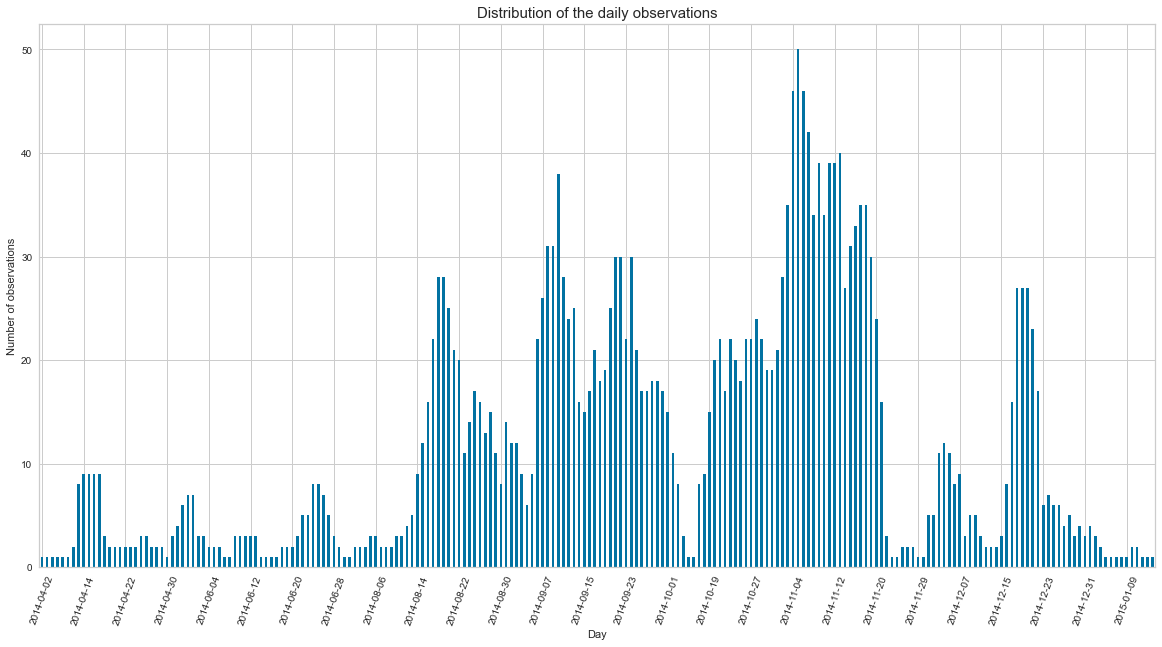

In [96]:
fig, ax = plt.subplots(figsize=(20,10))

df['datclin_day'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the daily observations",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of observations')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

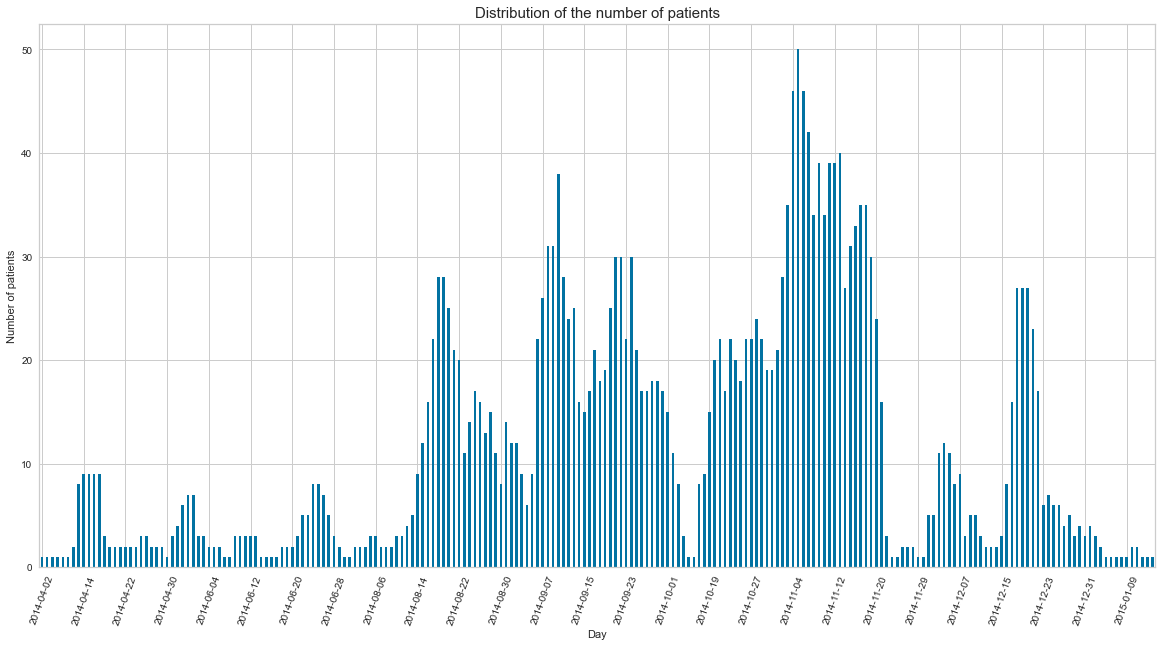

In [97]:
fig, ax = plt.subplots(figsize=(20,10))

df.groupby('datclin_day').msfid.nunique().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the number of patients",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of patients')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

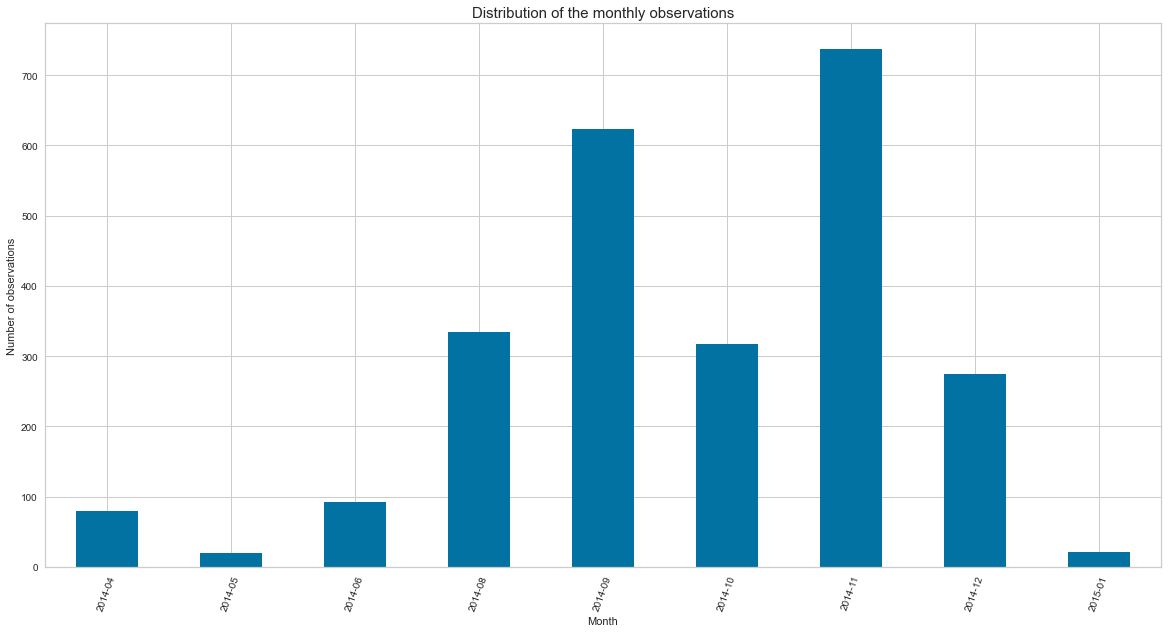

In [98]:
fig, ax = plt.subplots(figsize=(20,10))

df['datclin_month'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the monthly observations",size=15)
ax.set_xlabel('Month')
ax.set_ylabel('Number of observations')
plt.xticks(rotation=70)
plt.show()

#### Distribution of patients within the day

Please beware, this is plot for the initial dataframe (not with the 5 consecutive patients at the clinic dataframe)

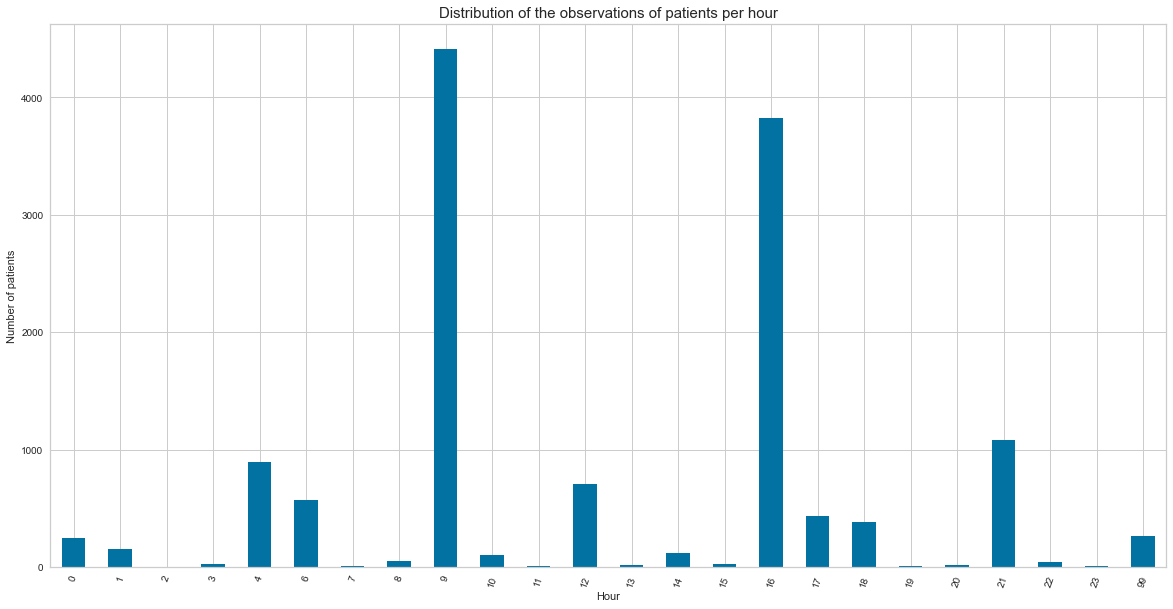

In [99]:
fig, ax = plt.subplots(figsize=(20,10))

df_clinical['timclin'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the observations of patients per hour",size=15)
ax.set_xlabel('Hour')
ax.set_ylabel('Number of patients')
plt.xticks(rotation=70)
plt.show()

The unknown hours are represented by 99.

### Categorical symptoms

Dictionary to the symptoms can be found in the folder 

In [100]:

symptoms = ['ceph', 'asthen', 'myalc', 'arthralc', 'fevr', 'oedc', 'chocc', 'anurc', 'convc', 'swallow', 'hiccups', \
            'anorc', 'nausc', 'vomit','abdopain', 'abdosens', 'doulqs', 'diarrc', 'gastro', 'cough', 'dyspc', 'resp', \
            'chestpain', 'vertpain', 'lombar', 'ictc', 'pruri', 'hepmeg', 'splenmeg', 'erupcut', 'deshyd', 'photoc', \
            'occulair', 'tremb', 'friss', 'vert', 'amenn', 'pros', 'desor', 'agitc', 'injconj', 'epista', \
            'gum', 'hemopty', 'hematem', 'stool', 'hemat', 'vagbl', 'injbl', 'petc']

In [101]:
df_symp = df[symptoms].copy()
df_symp.head()

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
df_symp

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2499,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Looking at possible missing data in symptoms

In [103]:


df_symp.isna().apply(lambda x: sum(x)).sort_values(ascending = False)

tremb        2291
pros         2288
occulair     2264
friss        2250
vert         2231
chocc        2223
lombar       2184
amenn        2153
convc        2117
abdosens     2067
resp         2034
gastro       2021
oedc         2015
doulqs       1959
agitc        1847
pruri        1686
vagbl         947
fevr          858
photoc        426
desor         178
anurc          92
vertpain       90
hemat          86
ictc           83
erupcut        68
injbl          65
abdopain       65
injconj        65
hiccups        64
arthralc       64
anorc          64
petc           64
ceph           64
stool          64
hematem        64
hemopty        64
gum            64
epista         64
cough          63
myalc          63
deshyd         63
swallow        63
splenmeg       63
hepmeg         63
nausc          63
chestpain      63
dyspc          63
vomit          61
asthen         61
diarrc         60
dtype: int64

These are the symptoms with many nan values ! We shall see their percentage and drop them in accordance

In [104]:
# Number of symptoms 
len(symptoms)

50

In [105]:
df_symp.fillna('Unknown', inplace = True)
df_symp.replace(1, 'Yes', inplace = True)
df_symp.replace(0, 'No', inplace = True)
df_symp

,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,convc,swallow,...,injconj,epista,gum,hemopty,hematem,stool,hemat,vagbl,injbl,petc
0,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
2,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,Unknown,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,No,No,No,No,Unknown,Unknown,Unknown,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
2498,No,No,No,No,Unknown,Unknown,Unknown,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
2499,No,No,No,No,No,Unknown,Unknown,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No
2500,No,No,No,No,No,Unknown,Unknown,No,Unknown,No,...,No,No,No,No,No,No,No,No,No,No


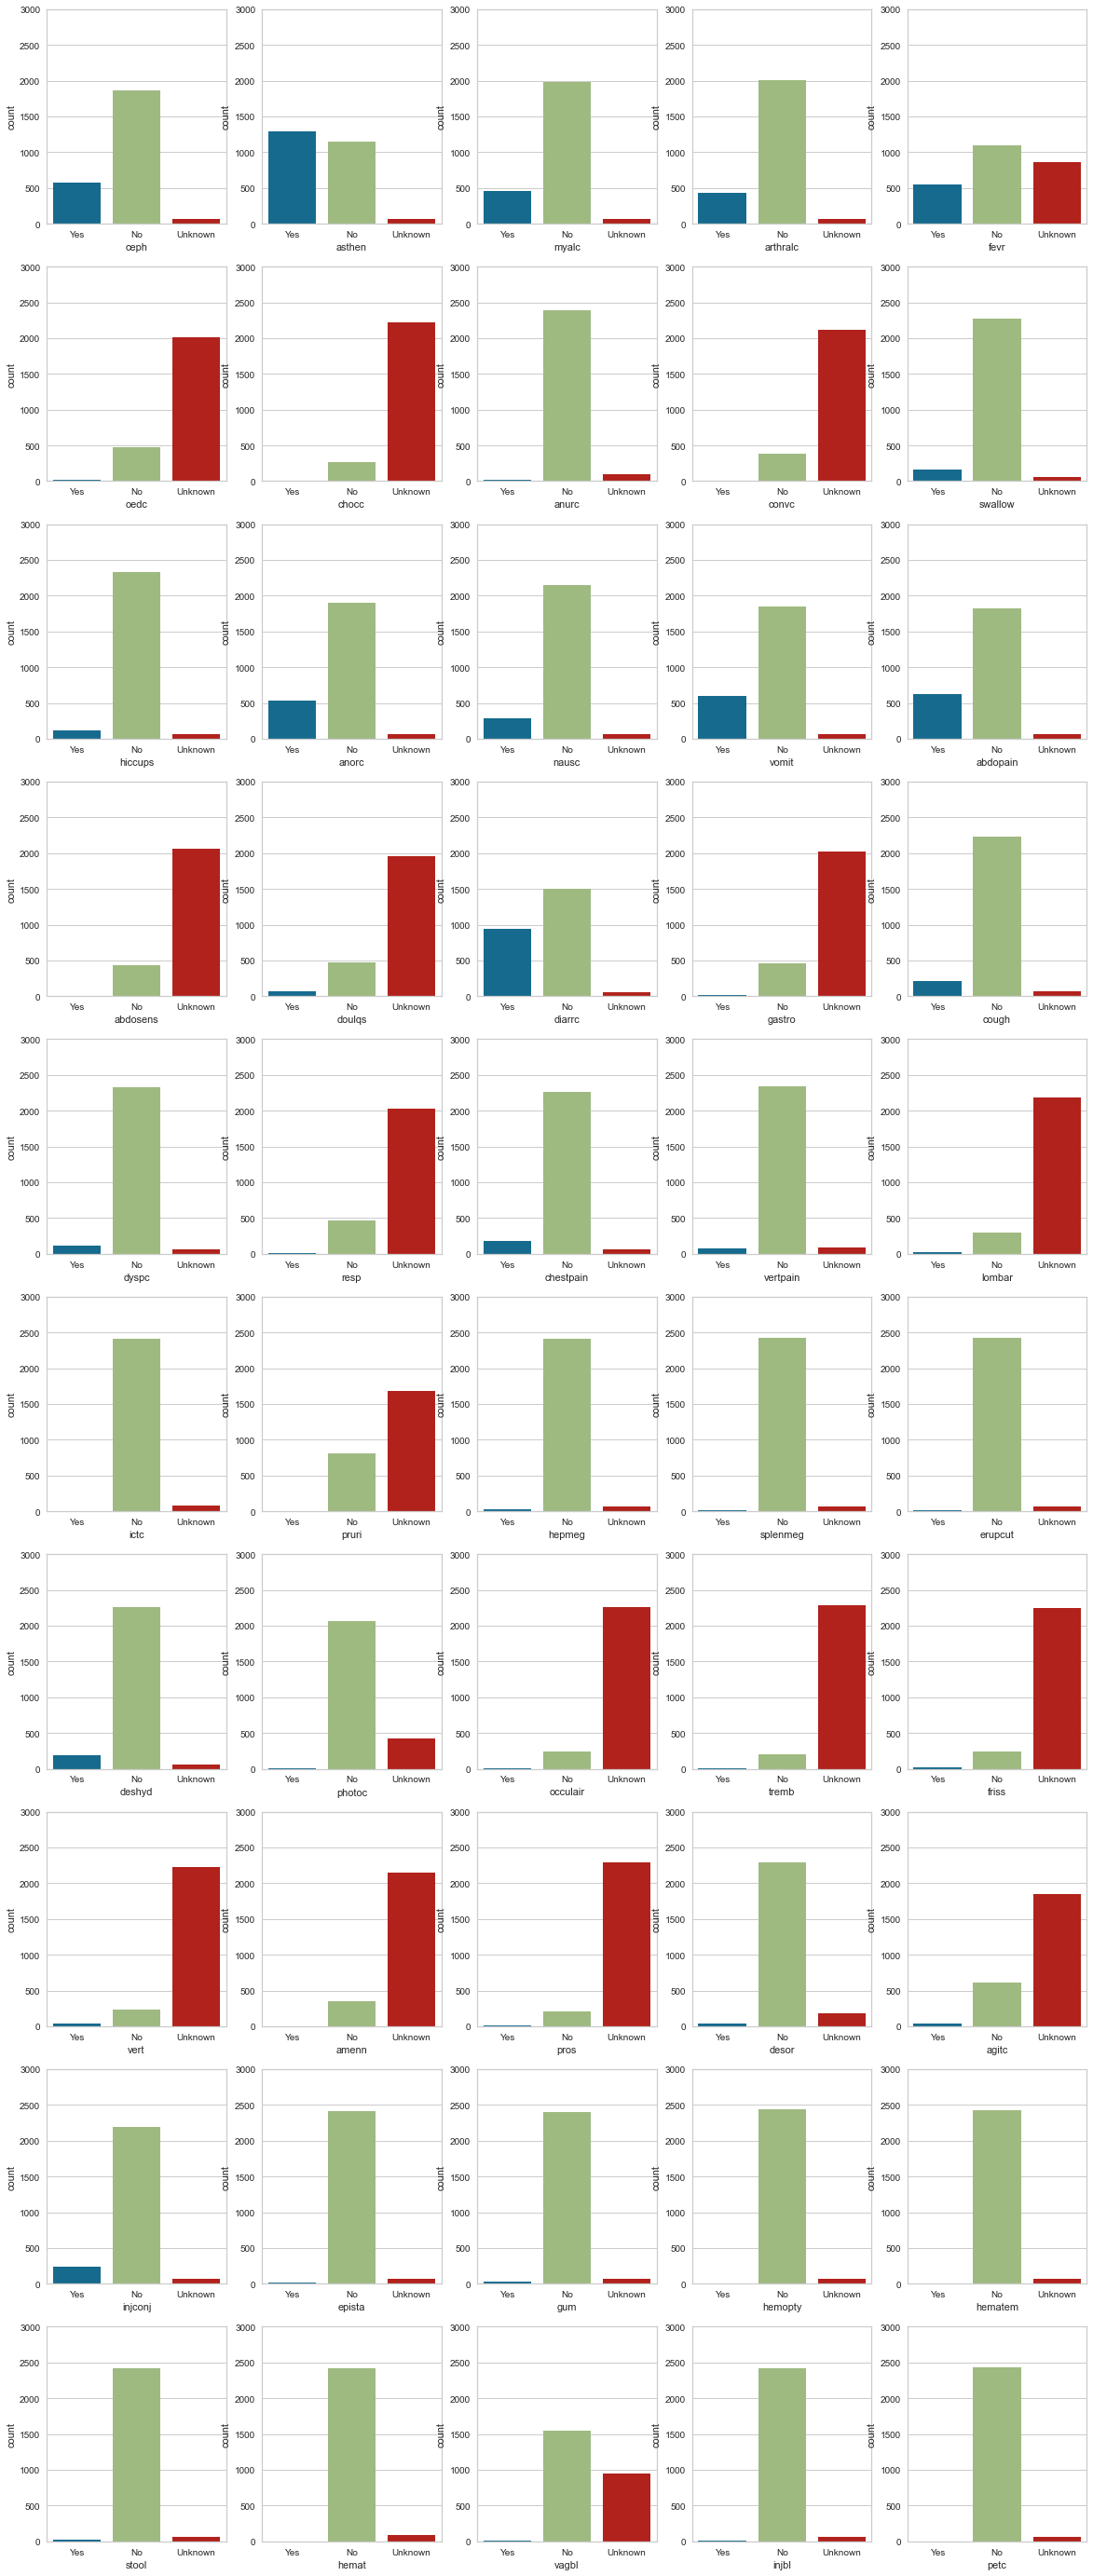

In [106]:
fig, axes = plt.subplots(nrows = 10, ncols=5, figsize=(20,50))
for ax, col in zip(axes.flatten(), df_symp.columns):
    sns.countplot(df_symp[col], ax = ax, order = ['Yes', 'No', 'Unknown'])
    #plt.title('Distribution of the symptom {}'.format(col))
    ax.set_ylim(0, 3000)

In [107]:
yes_series = df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 ).apply(lambda x :sum(x))
no_series = df_symp.applymap(lambda x : 1 if x== 'No' else 0 ).apply(lambda x :sum(x))
unknown_series = df_symp.applymap(lambda x : 1 if x== 'Unknown' else 0 ).apply(lambda x :sum(x))

In [108]:
count_symptoms = pd.concat([yes_series, no_series, unknown_series], axis=1)
count_symptoms.columns = ['Yes', 'No', 'Unknown']
total_observations = 13598
(count_symptoms / total_observations).sort_values(by ='Unknown')

,Yes,No,Unknown
diarrc,0.069201,0.110384,0.004412
asthen,0.094793,0.084718,0.004486
vomit,0.043904,0.135608,0.004486
dyspc,0.007942,0.171422,0.004633
chestpain,0.012722,0.166642,0.004633
nausc,0.021106,0.158259,0.004633
hepmeg,0.001839,0.177526,0.004633
splenmeg,0.000882,0.178482,0.004633
swallow,0.012428,0.166936,0.004633
deshyd,0.013458,0.165907,0.004633


#### Correlation between symptoms

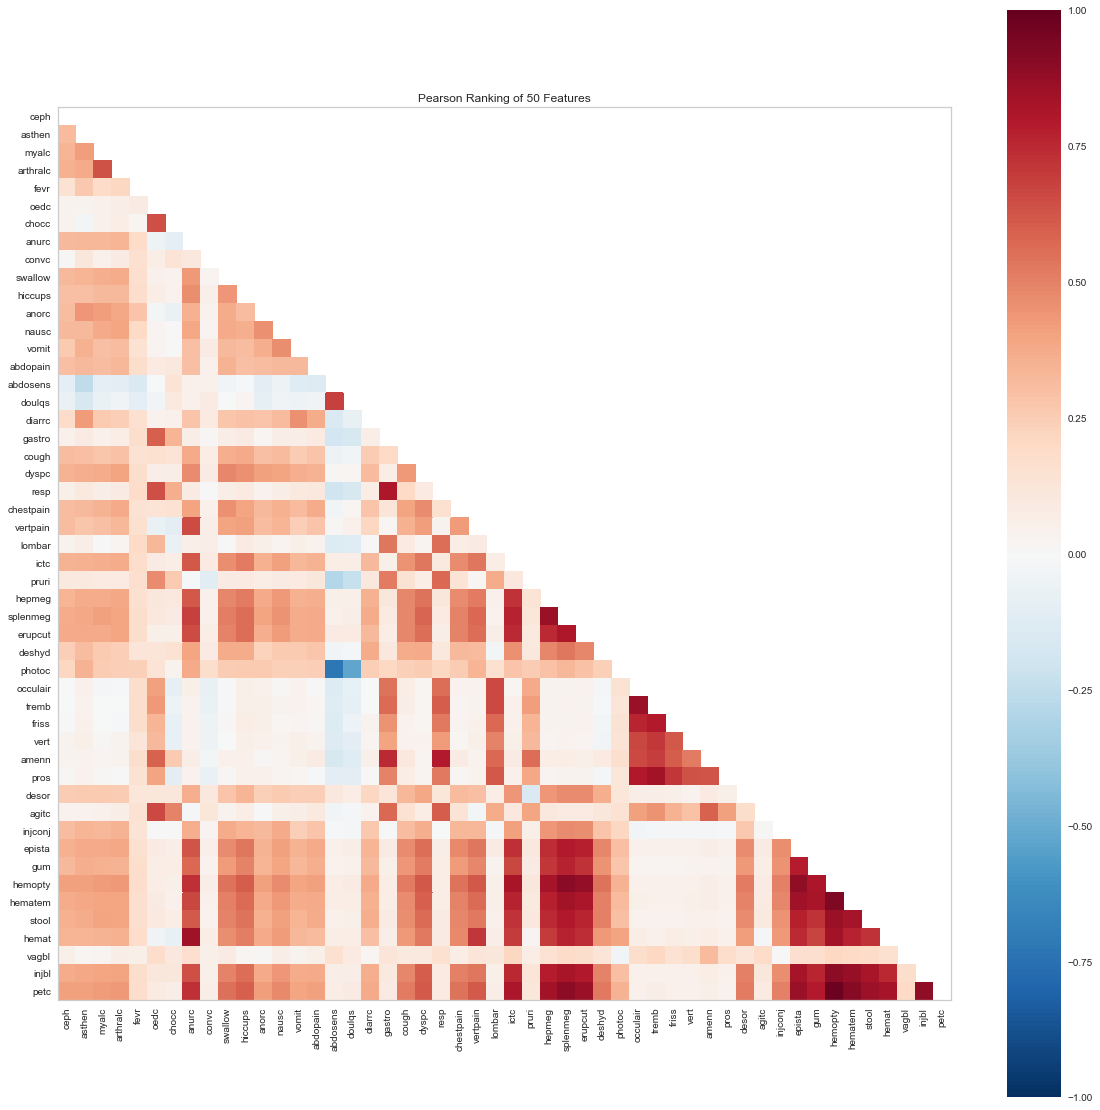

In [109]:
dict_symp = {'Unknown' : -1, 'No' : 0 , 'Yes' : 1}

Corr_vision(df_symp.applymap(lambda x : dict_symp[x]))

It is important to note that we cannot just remove highly correlated features, imagine big feat and vommiting had a high corelation because the few people you surveyed had both. If the model removes vomit but keep big feet, it would be really be understable 

In [110]:
#
df_naus_vom = df_symp.groupby(by = ['vomit','nausc'])[['nausc']].count()
df_naus_vom.columns = ['count']
df_naus_vom

count
vomit   nausc         
No      No        1743
        Yes        101
Unknown Unknown     61
Yes     No         409
        Unknown      2
        Yes        186

In [111]:
# abdosens does not bring much valuable infomration here, we remove it 

# Both abdosens and doulqs refer to pain in the chest area
df_sens = df_symp.groupby(by = ['abdosens','doulqs'])[['doulqs']].count()
df_sens.columns = ['count']
df_sens

count
abdosens doulqs        
No       No         416
         Unknown      2
         Yes         10
Unknown  No          50
         Unknown   1952
         Yes         65
Yes      No           2
         Unknown      5

In [112]:
df_symp = df_symp.drop(columns = ['abdosens'])

In [113]:
# Let's look at two similar breathing problems 
#Dyspnée (Short of Breath)
#signes détresse respiratry

df_resp = df_symp.groupby(by = ['dyspc','resp'])[['resp']].count()
df_resp.columns = ['count']
df_resp

count
dyspc   resp          
No      No         437
        Unknown   1892
        Yes          2
Unknown Unknown     63
Yes     No          26
        Unknown     79
        Yes          3

In [114]:
df_symp = df_symp.drop(columns = ['resp'])

In [115]:
# Back pain
df_back = df_symp.groupby(by = ['lombar','vertpain'])[['vertpain']].count()
df_back.columns = ['count']
df_back


count
lombar  vertpain       
No      No          283
        Yes           8
Unknown No         2035
        Unknown      90
        Yes          59
Yes     No           23
        Yes           4

In [116]:
df_symp = df_symp.drop(columns = ['lombar'])

In [117]:
# Eye pain/sensitivity
df_eye = df_symp.groupby(by = ['photoc','occulair'])[['occulair']].count()
df_eye.columns = ['count']
df_eye

# we can remove occulair as it provides no additional information

count
photoc  occulair       
No      No          236
        Unknown    1832
        Yes           2
Unknown Unknown     426
Yes     Unknown       6

In [118]:
df_symp = df_symp.drop(columns = ['occulair'])

<AxesSubplot:>

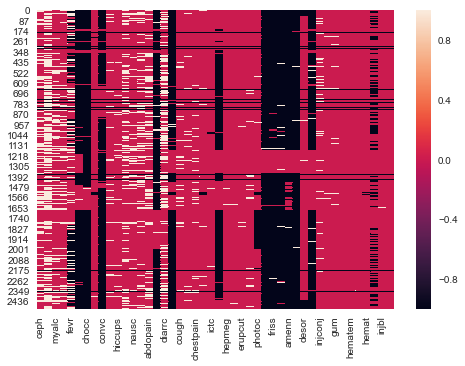

In [119]:
df_symp.eq('Unknown', axis=0).all(1)
sns.heatmap(df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 if x == 'No' else -1 ))

The black corresponds to unknowns

In [120]:
tot_rows = len(df_symp);

#### Missing column data

In [121]:
cols = df_symp.columns

df_symp[cols].eq('Unknown').sum(axis=0)/tot_rows 

# remove after 20 % 

# This represents the percentage of unknowns per feature (symptoms) the lower the better

ceph         0.025580
asthen       0.024380
myalc        0.025180
arthralc     0.025580
fevr         0.342926
oedc         0.805356
chocc        0.888489
anurc        0.036771
convc        0.846123
swallow      0.025180
hiccups      0.025580
anorc        0.025580
nausc        0.025180
vomit        0.024380
abdopain     0.025979
doulqs       0.782974
diarrc       0.023981
gastro       0.807754
cough        0.025180
dyspc        0.025180
chestpain    0.025180
vertpain     0.035971
ictc         0.033173
pruri        0.673861
hepmeg       0.025180
splenmeg     0.025180
erupcut      0.027178
deshyd       0.025180
photoc       0.170264
tremb        0.915667
friss        0.899281
vert         0.891687
amenn        0.860512
pros         0.914468
desor        0.071143
agitc        0.738209
injconj      0.025979
epista       0.025580
gum          0.025580
hemopty      0.025580
hematem      0.025580
stool        0.025580
hemat        0.034373
vagbl        0.378497
injbl        0.025979
petc      

### We decide to remove features (columns) with more than 20% missing data

In [122]:
list_keep = df_symp[cols].eq('Unknown').sum(axis=0)/tot_rows < 0.2


In [123]:
# New symptoms dataframe we keep 
df_symp = df_symp[df_symp.columns[list_keep]]


In [124]:
df_symp

,ceph,asthen,myalc,arthralc,anurc,swallow,hiccups,anorc,nausc,vomit,...,desor,injconj,epista,gum,hemopty,hematem,stool,hemat,injbl,petc
0,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
1,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
2,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
4,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,No,No,No,No,No,No,No,No,No,No,...,Unknown,No,No,No,No,No,No,No,No,No
2498,No,No,No,No,No,No,No,No,No,No,...,Unknown,No,No,No,No,No,No,No,No,No
2499,No,No,No,No,No,No,No,No,No,No,...,Unknown,No,No,No,No,No,No,No,No,No
2500,No,No,No,No,No,No,No,No,No,No,...,Unknown,No,No,No,No,No,No,No,No,No


It is interesting to note that the feautures with few missing values come from similar observations, but we cannot remove them as this would cause problems when concatenating on the days

**Possibility 1 :** Use categorical features for symptoms then need 1 hot encoding.

df_hot =df_symp.applymap(lambda x : 1 if x== 'Yes' else 0 )

df_hot.head()


**Possibility 2 :** Use numerical features for symptoms as the number of observed symptoms.

Now we want the cumulated observations per patient. 

**Possibility 3 :** Use binary features for symptoms as the presence of symtoms (1 for 'Yes' and 0 for 'No' or 'Unknown')

We can try to predict with these features, number of observations for which the symptom has been observed. 

df_presence_symp_patient = df_yes_symp_patient.applymap(lambda x: 1 if x>= 1 else 0 )
df_presence_symp_patient

In [125]:
# adding the patients identifier
df_symp = df_symp.join(pd.DataFrame(df[['datclin','msfid']]))

In [126]:
df_symp.replace('Yes', 1, inplace=True)
df_symp.replace('No', 0, inplace=True)
df_symp.replace('Unknown', np.nan, inplace=True)

In [127]:
df_symp

,ceph,asthen,myalc,arthralc,anurc,swallow,hiccups,anorc,nausc,vomit,...,epista,gum,hemopty,hematem,stool,hemat,injbl,petc,datclin,msfid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-04-11,G100
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-04-12,G100
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-04-13,G100
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-04-14,G100
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-04-15,G100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-09-17,G998
2498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-09-18,G998
2499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-09-19,G998
2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-09-20,G998


### Further data analysis 

We will drop the feature "cta" where the dictionary does is "not sure" of what it is and alos dup (no legend on dictionary)



In [128]:
df['cta'].value_counts(dropna=False)

0.0    1500
NaN     904
1.0      98
Name: cta, dtype: int64

In [129]:
df['dup'].value_counts(dropna=False)

0    2497
1       5
Name: dup, dtype: int64

In [130]:
df.drop(columns = ['dup','cta'], axis = 1, inplace = True)

### Treatments 

What shall I do with "parat" malaria test>
and "malari" malaria positive>

Fr now I only kept malari... No real reason

In [131]:
df['malari'].value_counts(dropna=False)

0.0    1341
NaN     880
1.0     281
Name: malari, dtype: int64

In [132]:
df['parat'].value_counts(dropna=False)

0.0    1281
NaN     843
1.0     378
Name: parat, dtype: int64

In [133]:
cols_treat = ['coartt', 'artest', 'ppnt',\
       'orst', 'paracett', 'ciprot', 'cefixt', 'ceftriaxt', 'multivitt',\
       'metaclot', 'omept', 'diazt', 'tramadt', 'ctrz','metro',\
       'amox', 'prometh', 'amoclav', 'genta', 'ampi', 'albend', 'azithro',\
       'chlor', 'morph', 'tetra', 'fluco', 'mysta', 'busco', 'miso',\
       'zinc', 'ivcare', 'rlt', 'rltg', 'rltk', 'gluc',\
       'perfal']
df_treat = df[cols_treat]

In [134]:
df_treat

,coartt,artest,ppnt,orst,paracett,ciprot,cefixt,ceftriaxt,multivitt,metaclot,...,mysta,busco,miso,zinc,ivcare,rlt,rltg,rltk,gluc,perfal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2499,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


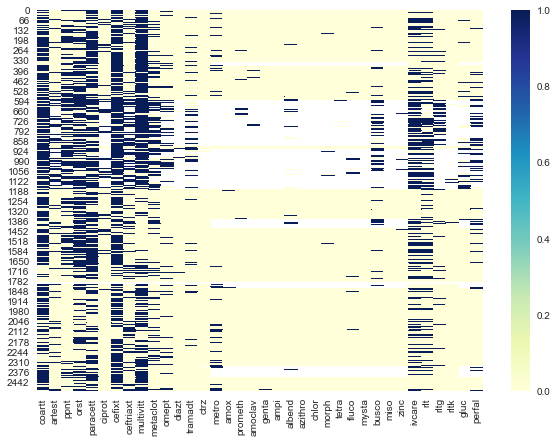

In [135]:
f, ax = plt.subplots(figsize=(10, 7))

ax = sns.heatmap(df_treat, cmap="YlGnBu")



In [136]:
df_treat

,coartt,artest,ppnt,orst,paracett,ciprot,cefixt,ceftriaxt,multivitt,metaclot,...,mysta,busco,miso,zinc,ivcare,rlt,rltg,rltk,gluc,perfal
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2499,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


#### Let us look at percentages with missing values in the treatments dataset


In [137]:
# % of missing values, if higher than 20% byebye
df_treat.isna().mean()

coartt       0.084732
artest       0.233014
ppnt         0.139488
orst         0.117906
paracett     0.107914
ciprot       0.248601
cefixt       0.093525
ceftriaxt    0.218225
multivitt    0.057154
metaclot     0.189848
omept        0.234612
diazt        0.276579
tramadt      0.241807
ctrz         0.292966
metro        0.364908
amox         0.368505
prometh      0.365707
amoclav      0.366906
genta        0.368905
ampi         0.368905
albend       0.356115
azithro      0.369305
chlor        0.369305
morph        0.366507
tetra        0.366507
fluco        0.365707
mysta        0.369305
busco        0.316547
miso         0.369305
zinc         0.365308
ivcare       0.169464
rlt          0.185452
rltg         0.247802
rltk         0.278977
gluc         0.336930
perfal       0.340528
dtype: float64

In [138]:
list_keep = df_treat[cols_treat].isna().mean() < 0.2


In [139]:
df_treat = df_treat[df_treat.columns[list_keep]]

In [140]:
# This is to help us merge later
df_treat = df_treat.join(pd.DataFrame(df[['msfid','datclin']]))

In [141]:
df_treat

,coartt,ppnt,orst,paracett,cefixt,multivitt,metaclot,ivcare,rlt,msfid,datclin
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G100,2014-04-11
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G100,2014-04-12
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,G100,2014-04-13
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,G100,2014-04-14
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,G100,2014-04-15
...,...,...,...,...,...,...,...,...,...,...,...
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998,2014-09-17
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998,2014-09-18
2499,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,G998,2014-09-19
2500,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,G998,2014-09-20


### Results

In [142]:
cols_test = ['malari', 'hivpos', 'mningit', 'encphal', 'erysip', \
       'cardio', 'fessier', 'epilep', 'mendis']

df_tests = df[cols_test]

In [143]:
# We also have the outcome, but it needs a dictionary ! 
df_clinical['outcome'].value_counts(dropna=False)

1    8285
2    5111
3      25
4       2
Name: outcome, dtype: int64

#### We are however only interested in healed or deceased in our case (for the outcome)
1	Guéri : Healed
2	Décédé : Deceased
3	Transferé : Transfered
4	Evadé : Escaped
9	Non rempli : Not filled in


In [144]:
dict_outcome = {1:1, 2:0, 9:np.nan, '.':np.nan, '0': np.nan,'1':1,'2':0,'4':np.nan,'3':np.nan}

In [145]:
df_5_days['outcome']= pd.DataFrame(data = df_5_days['outcome'].apply(lambda x : dict_outcome[x]))

C:\Users\Cedric\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [146]:
df_tests

,malari,hivpos,mningit,encphal,erysip,cardio,fessier,epilep,mendis
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2497,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2499,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2500,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Let us look at percentages with missing values in the treatments dataset
It is very high, but this might because we test the person once and that's it, so we it would be more accurate to verify that each patient has at least one non nan value



mmhhhh shit..........

In [147]:
df_tests

,malari,hivpos,mningit,encphal,erysip,cardio,fessier,epilep,mendis
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2497,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2499,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2500,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
df_tests.isna().mean()

malari     0.351719
hivpos     0.852918
mningit    0.854516
encphal    0.854916
erysip     0.854916
cardio     0.854117
fessier    0.853717
epilep     0.854916
mendis     0.846523
dtype: float64

In [149]:
# With the table above showing that only the malaria test has "usuable information" and with noting that most of the other
# features are nan or "no" (very few exceptions) we keep only malaria 

In [150]:
df_tests= df_tests.join(df['msfid'])

In [151]:
df_tests

,malari,hivpos,mningit,encphal,erysip,cardio,fessier,epilep,mendis,msfid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G100
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G100
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G100
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G100
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G100
...,...,...,...,...,...,...,...,...,...,...
2497,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998
2498,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998
2499,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998
2500,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998


In [152]:
dict_read_tests = {
    0  : 1,
    1  : 100,
    '0': 1,
    '1': 100,
    'NaN': 0
}

df_tests['malari'] = df_tests['malari'].fillna('NaN').apply(lambda x : dict_read_tests[x])

In [153]:
df_te = df_tests[['malari','msfid']]

In [154]:
df_te

,malari,msfid
0,0,G100
1,0,G100
2,0,G100
3,0,G100
4,0,G100
...,...,...
2497,100,G998
2498,100,G998
2499,100,G998
2500,100,G998


In [155]:
df_tr_count = df_te.groupby(by = 'msfid').sum()


In [156]:
df_tr_count

,malari
msfid,
G100,0
G1002,4
G1005,5
G1006,5
G1007,5
...,...
G991,5
G992,5
G993,5


In [157]:
df_tr_count[(df_tr_count['malari'] == 0)] = np.nan
df_tr_count[(df_tr_count['malari'] < 99)] = 0
df_tr_count[(df_tr_count['malari'] > 99)] = 1


In [158]:
df_tr_count

,malari
msfid,
G100,NaN
G1002,0.0
G1005,0.0
G1006,0.0
G1007,0.0
...,...
G991,0.0
G992,0.0
G993,0.0


The data frame will be composed of 
- df_sympt
- df_treat
- df_out (for outcome)
- df_tests
- The msfid
- dt
- datclin
- Time stayed
- age / sex

In [159]:
df_5_days['fevtemp'].value_counts()

99.0    2272
37.0     173
36.7     162
36.6     159
36.5     141
        ... 
32.1       1
32.0       1
32.6       1
33.4       1
33.9       1
Name: fevtemp, Length: 80, dtype: int64

In [160]:
df

,msfid,datclin,ceph,asthen,myalc,arthralc,fevr,oedc,chocc,anurc,...,datsym,age,sex,dt,first_date,Time_stayed,fevtemp,conscc,datclin_day,datclin_month
0,G100,2014-04-11,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,2014-04-09,40.0,1.0,2.0,2014-04-11,10,38.300000,NaN,2014-04-11,2014-04
1,G100,2014-04-12,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,2014-04-09,40.0,1.0,3.0,2014-04-11,10,37.400000,NaN,2014-04-12,2014-04
2,G100,2014-04-13,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,2014-04-09,40.0,1.0,4.0,2014-04-11,10,37.150000,NaN,2014-04-13,2014-04
3,G100,2014-04-14,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,2014-04-09,40.0,1.0,5.0,2014-04-11,10,37.650000,NaN,2014-04-14,2014-04
4,G100,2014-04-15,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,2014-04-09,40.0,1.0,6.0,2014-04-11,10,36.966667,NaN,2014-04-15,2014-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,G998,2014-09-17,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,2014-09-18,6.0,1.0,-1.0,2014-09-17,9,34.900000,NaN,2014-09-17,2014-09
2498,G998,2014-09-18,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,...,2014-09-18,6.0,1.0,0.0,2014-09-17,9,38.000000,NaN,2014-09-18,2014-09
2499,G998,2014-09-19,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,2014-09-18,6.0,1.0,1.0,2014-09-17,9,38.500000,NaN,2014-09-19,2014-09
2500,G998,2014-09-20,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,2014-09-18,6.0,1.0,2.0,2014-09-17,9,38.050000,NaN,2014-09-20,2014-09


In [161]:
df_5_days['outcome']

0        1.0
1        1.0
3        1.0
4        1.0
5        1.0
        ... 
12047    1.0
12048    1.0
12050    1.0
12051    1.0
12052    1.0
Name: outcome, Length: 5949, dtype: float64

In [162]:
df_5_days[['outcome','msfid']]

,outcome,msfid
0,1.0,G100
1,1.0,G100
3,1.0,G100
4,1.0,G100
5,1.0,G100
...,...,...
12047,1.0,G2493
12048,1.0,G2493
12050,1.0,G2493
12051,1.0,G2493


In [163]:
df_5_days[['outcome','msfid']].groupby(by='msfid').nunique()['outcome'].value_counts()

1    517
0      1
Name: outcome, dtype: int64

#### We noticed some observations had nan values in outcome, since we are trying to predict it, we cannot keep that

In [164]:

df_5_days['outcome'].value_counts(dropna= False)

1.0    3448
0.0    2492
NaN       9
Name: outcome, dtype: int64

In [165]:
# Here we see it's the same patient with an unknown outcome, we thus disregard the patient
df_5_days[df_5_days['outcome'].isna()]

,msfid,datclin,timclin,unid,ceph,asthen,myalc,arthralc,fevr,oedc,...,notesread,dup,datsym,epistat,outcome,age,sex,dt,first_date,Time_stayed
2238,G674,2014-08-21,16,G674_21aug2014_16,1,1,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,5.0,2014-08-21,11
2239,G674,2014-08-22,6,G674_22aug2014_6,0,1,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,6.0,2014-08-21,11
2240,G674,2014-08-22,11,G674_22aug2014_11,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,6.0,2014-08-21,11
2257,G674,2014-08-23,21,G674_23aug2014_21,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,7.0,2014-08-21,11
2258,G674,2014-08-23,16,G674_23aug2014_16,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,7.0,2014-08-21,11
2259,G674,2014-08-22,21,G674_22aug2014_21,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,6.0,2014-08-21,11
2260,G674,2014-08-25,21,G674_25aug2014_21,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,9.0,2014-08-21,11
2261,G674,2014-08-25,9,G674_25aug2014_9,0,1,0,0,8,1,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,9.0,2014-08-21,11
2262,G674,2014-08-24,16,G674_24aug2014_16,0,0,0,0,8,8,...,Yes,0,2014-08-16,1.0,NaN,40.0,1.0,8.0,2014-08-21,11


In [166]:
# We remove the patient who's outcome is unknown 
df_5_days = df_5_days[df_5_days['msfid'] != 'G674']

In [167]:
# We put max as a patient who was once dead is not coming back alive 
df_out = df_5_days[['outcome','msfid']].groupby(by = 'msfid').max().reset_index()

In [168]:
df_out

,msfid,outcome
0,G100,1.0
1,G1002,1.0
2,G1005,0.0
3,G1006,1.0
4,G1007,1.0
...,...,...
512,G991,1.0
513,G992,0.0
514,G993,1.0
515,G994,0.0


In [169]:
df_extract = pd.DataFrame(data = df[['msfid','sex','age','datclin','datsym', 'dt','first_date','Time_stayed']])
df_extract

,msfid,sex,age,datclin,datsym,dt,first_date,Time_stayed
0,G100,1.0,40.0,2014-04-11,2014-04-09,2.0,2014-04-11,10
1,G100,1.0,40.0,2014-04-12,2014-04-09,3.0,2014-04-11,10
2,G100,1.0,40.0,2014-04-13,2014-04-09,4.0,2014-04-11,10
3,G100,1.0,40.0,2014-04-14,2014-04-09,5.0,2014-04-11,10
4,G100,1.0,40.0,2014-04-15,2014-04-09,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...
2497,G998,1.0,6.0,2014-09-17,2014-09-18,-1.0,2014-09-17,9
2498,G998,1.0,6.0,2014-09-18,2014-09-18,0.0,2014-09-17,9
2499,G998,1.0,6.0,2014-09-19,2014-09-18,1.0,2014-09-17,9
2500,G998,1.0,6.0,2014-09-20,2014-09-18,2.0,2014-09-17,9


In [170]:
df_extract

,msfid,sex,age,datclin,datsym,dt,first_date,Time_stayed
0,G100,1.0,40.0,2014-04-11,2014-04-09,2.0,2014-04-11,10
1,G100,1.0,40.0,2014-04-12,2014-04-09,3.0,2014-04-11,10
2,G100,1.0,40.0,2014-04-13,2014-04-09,4.0,2014-04-11,10
3,G100,1.0,40.0,2014-04-14,2014-04-09,5.0,2014-04-11,10
4,G100,1.0,40.0,2014-04-15,2014-04-09,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...
2497,G998,1.0,6.0,2014-09-17,2014-09-18,-1.0,2014-09-17,9
2498,G998,1.0,6.0,2014-09-18,2014-09-18,0.0,2014-09-17,9
2499,G998,1.0,6.0,2014-09-19,2014-09-18,1.0,2014-09-17,9
2500,G998,1.0,6.0,2014-09-20,2014-09-18,2.0,2014-09-17,9


In [171]:
df_tr_count

,malari
msfid,
G100,NaN
G1002,0.0
G1005,0.0
G1006,0.0
G1007,0.0
...,...
G991,0.0
G992,0.0
G993,0.0


In [172]:
df_treat

,coartt,ppnt,orst,paracett,cefixt,multivitt,metaclot,ivcare,rlt,msfid,datclin
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G100,2014-04-11
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,G100,2014-04-12
2,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,G100,2014-04-13
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,G100,2014-04-14
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,G100,2014-04-15
...,...,...,...,...,...,...,...,...,...,...,...
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998,2014-09-17
2498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G998,2014-09-18
2499,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,G998,2014-09-19
2500,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,G998,2014-09-20


In [173]:
df_extract

,msfid,sex,age,datclin,datsym,dt,first_date,Time_stayed
0,G100,1.0,40.0,2014-04-11,2014-04-09,2.0,2014-04-11,10
1,G100,1.0,40.0,2014-04-12,2014-04-09,3.0,2014-04-11,10
2,G100,1.0,40.0,2014-04-13,2014-04-09,4.0,2014-04-11,10
3,G100,1.0,40.0,2014-04-14,2014-04-09,5.0,2014-04-11,10
4,G100,1.0,40.0,2014-04-15,2014-04-09,6.0,2014-04-11,10
...,...,...,...,...,...,...,...,...
2497,G998,1.0,6.0,2014-09-17,2014-09-18,-1.0,2014-09-17,9
2498,G998,1.0,6.0,2014-09-18,2014-09-18,0.0,2014-09-17,9
2499,G998,1.0,6.0,2014-09-19,2014-09-18,1.0,2014-09-17,9
2500,G998,1.0,6.0,2014-09-20,2014-09-18,2.0,2014-09-17,9


In [174]:
df_pre =df_out.merge(df_tr_count, how = 'inner', on = 'msfid').merge(df_treat,how = 'inner', on = 'msfid').merge(df_extract,how = 'inner', on = ['msfid','datclin']).merge(df_symp,how = 'inner', on = ['msfid','datclin'])

#### We finally have a data frame that is grouped by day with each patient, whose outcomes are known 

In [175]:
df_pre['outcome']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2492    0.0
2493    0.0
2494    0.0
2495    0.0
2496    0.0
Name: outcome, Length: 2497, dtype: float64

# Separation between days 

We will now concatenate using a "home-made" function which you can learn more about on the helper/read_me the different days, each patient will thus have 5 consecutive days of features which change with time

In [176]:
df_day = transform_into_horizontal_df(df_pre)

In [177]:
df_day

,msfid,malari,coartt,ppnt,orst,paracett,cefixt,multivitt,metaclot,ivcare,...,gum,hemopty,hematem,stool,hemat,injbl,petc,time_elapsed,sex,outcome
0,G100,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,1.0
1,G1002,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2.0,1.0
2,G1005,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,0.0
3,G1006,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2.0,1.0
4,G1007,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,G991,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,2.0,1.0
513,G992,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,0.0
514,G993,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,1.0
515,G994,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4 days,1.0,0.0


In [178]:
df_day['outcome']

0      1.0
1      1.0
2      0.0
3      1.0
4      1.0
      ... 
512    1.0
513    0.0
514    1.0
515    0.0
516    0.0
Name: outcome, Length: 517, dtype: float64

In [216]:
# code taken from stackoverflow 
#(https://stackoverflow.com/questions/43095955/rename-duplicated-index-values-pandas-dataframe)
def differentiante_names(data_frame):
    df_transposed = data_frame.transpose(copy=True)
    df_transposed.index = df_transposed.index + df_transposed.groupby(level=0).cumcount().astype(str).replace('0','')
    return df_transposed.transpose(copy=True)

In [217]:
df_day2 = differentiante_names(df_day)

In [224]:
df_day2

,msfid,malari,coartt,ppnt,orst,paracett,cefixt,multivitt,metaclot,ivcare,...,gum4,hemopty4,hematem4,stool4,hemat4,injbl4,petc4,time_elapsed4,sex,outcome
0,G100,NaN,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,4 days,1,1
1,G1002,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,4 days,2,1
2,G1005,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4 days,1,0
3,G1006,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,4 days,2,1
4,G1007,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,4 days,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,G991,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4 days,2,1
513,G992,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,4 days,1,0
514,G993,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,4 days,1,1
515,G994,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,4 days,1,0


## What is left to do ?
 - drop rows with only NaNs
 - Deal with Naans in general : Just set them to zero ?
 - Also drop columns with too much emptiness
 - 1-hot encoding for sex and cathegorical values (see Ridha's if needed)
 - 

In [225]:
threshold = 0.2
twenypercent = len(df_day)*threshold

#df_day[list(df_day.isna().sum(axis=0) > 100)]
df_day2.columns[df_day2.isna().sum(axis=0)>twenypercent]

Index(['malari', 'metaclot', 'ivcare', 'rlt', 'malari1', 'metaclot1',
       'ivcare1', 'rlt1', 'photoc1', 'malari2', 'metaclot2', 'ivcare2', 'rlt2',
       'photoc2', 'malari3', 'malari4'],
      dtype='object')